In [213]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, root_scalar
import scipy.linalg as la
from scipy.interpolate import interp1d
import sys
if ".." not in sys.path: sys.path.append("..")
from common import constants, cosmology
#from scikits.odes.odeint import odeint
from mpmath import mp
mp.dps = 30

# $\mathrm{B} - \mathrm{L}$ Genesis

## Warning: for different epoch change numbers!

## Rates for Different Processes

### Yukawa Rates

In [214]:

Y_tau = 1e-2
Y_top = 0.49
Y_bottom = 6.8e-3

kappa_tau = 1.7e-3

def calc_yukawa_rate(T, kappa, Y):
    return kappa * Y**2 * T**4

def calc_yukawa_rate_tau(T):
    return calc_yukawa_rate(T, kappa_tau, Y_tau)

kappa_quarks_uptype = np.array([8e-3, 1e-2, 1.2e-2]) # \approx downtype
T_for_kappa_quarks_uptype = np.array([1e15, 1e12, 1e9])
kappa_quark_uptype_interp = interp1d(T_for_kappa_quarks_uptype, kappa_quarks_uptype)

def calc_yukawa_rate_quark(T, Y):
    kappa = kappa_quarks_uptype[1] # kappa_quark_interp(T)
    return calc_yukawa_rate(T, kappa, Y)

def calc_yukawa_rate_top(T):
    return calc_yukawa_rate_quark(T, Y_top)

def calc_yukawa_rate_bottom(T):
    return calc_yukawa_rate_quark(T, Y_bottom)

### Sphaleron Rates

In [302]:
g2 = 0.55
g3 = 0.6

def g_to_alpha(g): return g**2 / (4*np.pi)

alpha_2 = g_to_alpha(g2)
alpha_3 = g_to_alpha(g3)

kappa_WS = 24 # for 1e12 GeV
kappa_SS = 2.7e2 # for 1e13 GeV

def calc_weak_sphaleron_rate(T):
    return kappa_WS / 2 * alpha_2**5 * T**4

def calc_strong_sphaleron_rate(T):
    return kappa_SS / 2 * alpha_3**5 * T**4

### Weinberg Rate 

In [303]:
kappa_W = 3e-3
nu_EW = 174 # [GeV]
m_nu = 0.05e-9

def calc_weinberg_op_rate(T):
    return kappa_W * m_nu**2 * T**6 / nu_EW**4

## Rate Vector and Equilibration Temperatures

In [236]:
def calc_rate_vector(T):
    return np.array((
        calc_weak_sphaleron_rate(T), # WS
        calc_strong_sphaleron_rate(T), # SS
        calc_yukawa_rate_tau(T), # Y_tau
        calc_yukawa_rate_top(T), # Y_top
        calc_yukawa_rate_bottom(T), # Y_bottom
        #2 * calc_weinberg_op_rate(T), # W_12
        calc_weinberg_op_rate(T), # W_12
        calc_weinberg_op_rate(T), # W_3
    ))

In [317]:
def eqi_temp(alpha, plot=True, low=1e10, high=1e16):
    def ratio(T):
        gamma = calc_rate_vector(T)[alpha] / (T**3 / 6)
        expr = np.sum(charge_vector[alpha, :]**2 / g * gamma)
        H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
        return expr / H

    T_range = np.geomspace(high, low, 200)
    if plot: plt.loglog(T_range, [ratio(T) for T in T_range], label=process_names[alpha])
    
    try:
        sol = root_scalar(lambda T: ratio(T) - 1, bracket=(T_range[0], T_range[-1]))
        if not sol.converged: return np.nan
    except ValueError:
        return np.nan
    return sol.root

WS 2.485122e+12 GeV
SS 4.449330e+13 GeV
Y_tau 1.270354e+12 GeV
Y_top 7.689376e+15 GeV
Y_bottom 1.480869e+12 GeV
W_12 1.431094e+13 GeV
W_3 9.540625e+12 GeV


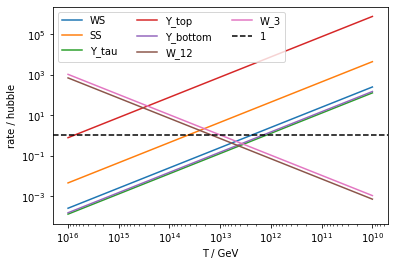

In [320]:
T_eqs = [eqi_temp(alpha) for alpha in range(charge_vector.shape[0])]
plt.axhline(1, ls="--", color="black", label="1")
plt.legend(ncol=3)
plt.gca().invert_xaxis()
plt.xlabel("T / GeV")
plt.ylabel("rate / hubble")
for name, T_eq in zip(process_names, T_eqs):
    print(name, "%e" % T_eq, "GeV")

## Charge and Source Vectors

In [217]:
charge_vector = np.array((
    # Interactions:
    # tau, L12, L3, q12, t,  b,  Q12, Q3,  H
    (0,    2,   1,  0,   0,  0,  6,   3,   0), # WS
    (0,    0,   0, -4,  -1, -1,  4,   2,   0), # SS
    (-1,   0,   1,  0,   0,  0,  0,   0,   1), # Y_tau
    (0,    0,   0,  0,  -1,  0,  0,   1,   1), # Y_top
    (0,    0,   0,  0,   0, -1,  0,   1,  -1), # Y_bottom
    (0,    2,   0,  0,   0,  0,  0,   0,   2), # Weinberg_12
    (0,    0,   2,  0,   0,  0,  0,   0,   2), # Weinberg_3
    # Conserved Quantaties:
    # tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
    #( -1, -1/2, -1/2,  1/6,  2/3, -1/3, 1/6,  1/6, 1/2), # Y
    #(  0,  0,    0,    1/3, -2/3, -2/3, 1/3, -2/3, 0),   # B12 - 2*B3
))

In [218]:
g = dofs = np.array([1,4,2,12,3,3,12,6,4])

In [223]:
#                                           WS SS  Ytau Yt Yb  W12  W3 
source_vector_B_minus_L_current = np.array((0,  0,  0,  0,  0, -2, -2))
source_vector_weak_sphaleron    = np.array((1,  0,  0,  0,  0,  0,  0))
source_vector_strong_sphaleron  = np.array((0,  1,  0,  0,  0,  0,  0))

In [225]:
charge_names = ["tau", "L12", "L3", "q12", "t", "b", "Q12", "Q3", "H"]

## Axion Motion

In [ ]:
# a dot / f / T
eta0 = 1e-9
def calc_axion_motion(log_T):
    return eta0

## $\mathrm{B} - \mathrm{L}$ Charge

In [226]:
charge_vector_B_minus_L = np.array((-1, -1, -1, 1/3, 1/3, 1/3, 1/3, 1/3, 0))
def calc_B_minus_L(red_chems):
    return charge_vector_B_minus_L @ red_chems

## Transport Equation

In [239]:
def rate(log_T):
    T = np.exp(log_T)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    Gamma = calc_rate_vector(T)
    gamma = Gamma / (T**3 / 6)
    return gamma / H

In [321]:
unit = 1e-10
def transport_eq_rhs(log_T, red_chem_pot, n_S):
    R = rate(log_T)
    axion_motion = calc_axion_motion(log_T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(charge_vector[alpha, i] * R[alpha] * 
                       (np.dot(charge_vector[alpha, :], red_chem_pot)
                        - n_S[alpha] * axion_motion / unit) 
                    for alpha in range(charge_vector.shape[0]))
            for i in range(charge_vector.shape[1])])
    return d_red_chem_pot_d_ln_T

In [322]:
def transport_eq_jac(log_T, _ignore_y, *_ignore_args):
    R = rate(log_T)
    def jac(i, j):
        return sum(1 / g[i] * charge_vector[alpha, i] * charge_vector[alpha, j] * R[alpha]
                  for alpha in range(charge_vector.shape[0]))
    return np.array([[jac(i,j) for j in range(charge_vector.shape[1])] for i in range(charge_vector.shape[1])])

In [334]:
initial = np.zeros(charge_vector.shape[1])
T_RH = 1e15
start, end = np.log(T_RH), np.log(1e10)
steps = np.linspace(start, end, 500); steps[0] = start; steps[-1] = end

In [330]:
# RK23 RK45 DOP853 Radau BDF LSODA
sol = solve_ivp(transport_eq_rhs, (start, end), initial, jac=transport_eq_jac,
         args=(source_vector_weak_sphaleron,), method="Radau", rtol=1e-8, t_eval=steps)
red_chem_pots = sol.y * unit
T = np.exp(sol.t)
red_chem_B_minus_L = calc_B_minus_L(red_chem_pots)

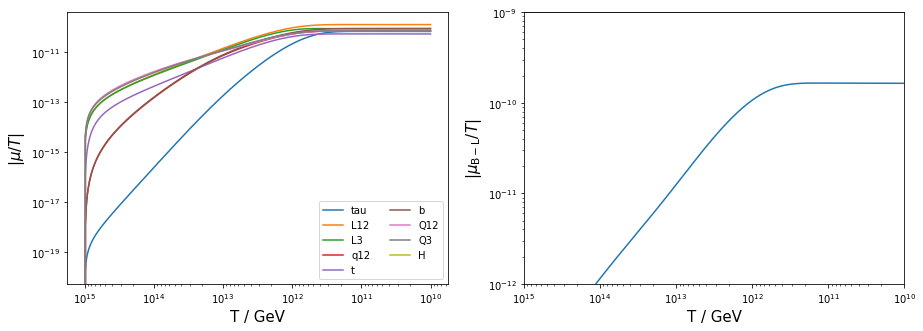

In [331]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for name, red_chem_pot in zip(charge_names, red_chem_pots):
    plt.loglog(T, red_chem_pot, label=name)
plt.ylabel(r"$|\mu / T|$", fontsize=15)
plt.xlabel(r"T / GeV", fontsize=15)
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.subplot(1,2,2)
plt.loglog(T, np.abs(red_chem_B_minus_L))
plt.axhline(1e-9)
plt.ylabel(r"$|\mu_{\mathrm{B} - \mathrm{L}} / T|$", fontsize=15)
plt.xlabel(r"T / GeV", fontsize=15)
plt.gca().invert_xaxis()
plt.ylim(1e-12, 1e-9)
plt.xlim(1e15, 1e10)
plt.show()